# **Fraud Detection Project**

### Importing Necassary Libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, classification_report, roc_auc_score, f1_score, recall_score)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [59]:
# Retrieving the dataset
df = pd.read_csv("fraud_data1.csv", na_values='?')
df = df.dropna()

### Correlation Matrix Between Features Using HeatMap

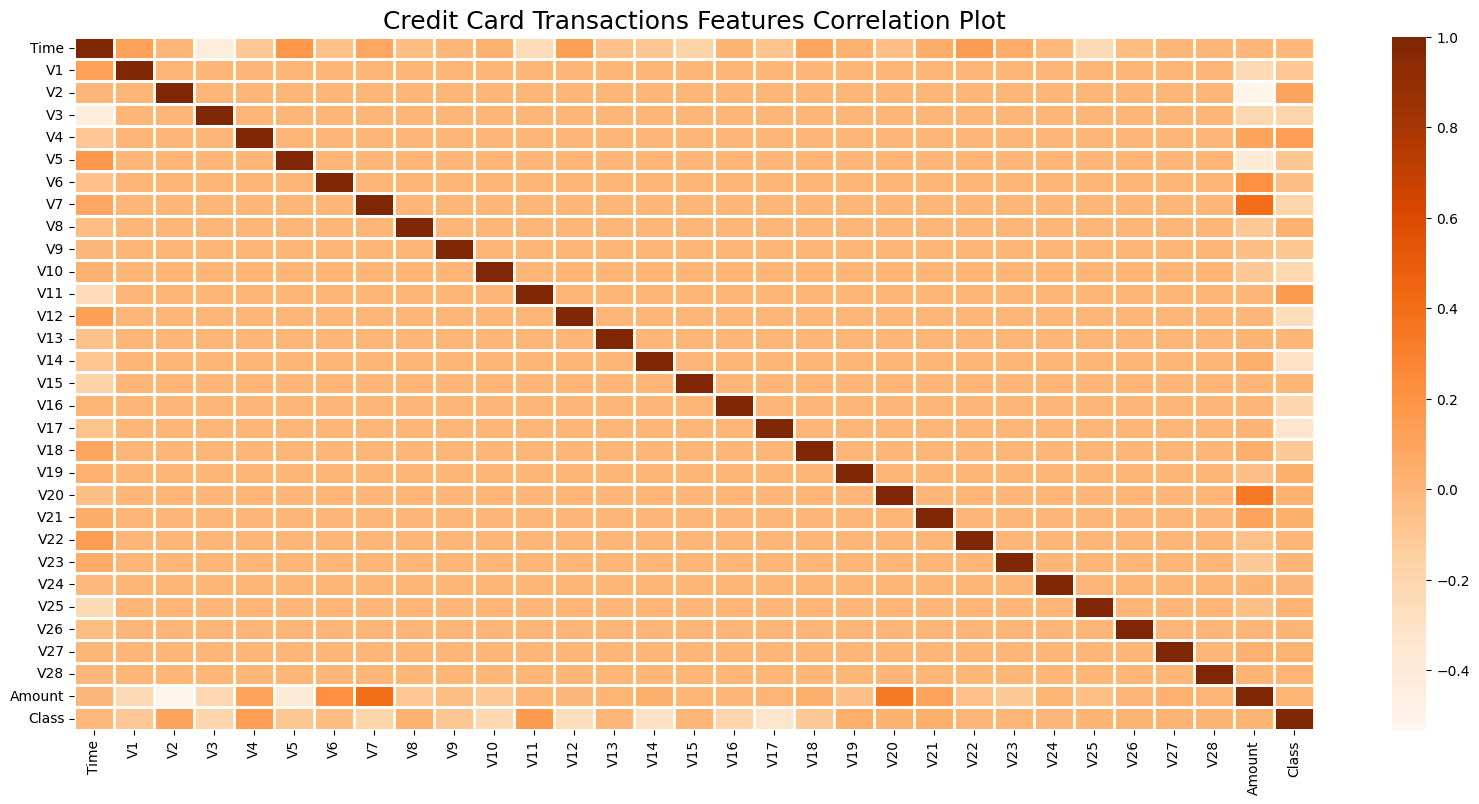

In [60]:
# Correlation table
correlation = df.corr()
correlation["Class"].sort_values(ascending=False)
# Plotting Corr. Matrix
plt.figure(figsize=(20, 9))
plt.title("Credit Card Transactions Features Correlation Plot", fontsize=18)
sns.heatmap(
    correlation,
    xticklabels=correlation.columns,
    yticklabels=correlation.columns,
    linewidth=2,
    cmap="Oranges",
    cbar=True,
)
plt.show()

### Eliminating features whose correlation value is greater than 0.75 

In [61]:
columns = list(df.columns)
for column in columns:
    # Skip Class column
    if column == "Class":
        continue
    filtered_columns = [column]
    # Iterate through HeatMap
    for col in df.columns:
        # Skip the diagonals and the class columns
        if (column == col) | (column == "Class"):
            continue
        # Retrieving corr val from df
        cor_val = df[column].corr(df[col])
        # Setting threshold to be 70%
        if cor_val > 0.75:
            columns.remove(col)
            continue
        else:
            filtered_columns.append(col)
    # Keeping only filtered columns
    df = df[filtered_columns]

features = df.drop(["Class"], axis=1)
# We are gonig to scale the featrues with MinMax Scaler
mm_scaler = MinMaxScaler((0,1))
X = mm_scaler.fit_transform(features)

#<--> Lines (31-33) Cited

# Using Chi Squared to filter columns
selector = SelectKBest(chi2, k=21)
selector.fit(X, df["Class"])
filtered_columns = selector.get_support()

# Adding Class column back to dataframe
filtered_data = features.loc[:, filtered_columns]
df = filtered_data.join(df["Class"])

print("After filtering highly correlated features, dataset is ", df.shape)

After filtering highly correlated features, dataset is  (284807, 22)


### Observation
Let's observe the dataset and find connection between fraudulant and normal transactions. 

In [62]:
#temp_df = df.sort_values(by = ["Time"])
frauds = df.query("Class == 1")
normals = df.query("Class == 0")
total = len(df)
fraud_percent = round((len(frauds) / total)*100, 2)
print("The percentage of fraudulant transactions is: ", fraud_percent)

The percentage of fraudulant transactions is:  0.17


As the percentage of fraudulant transactions is trivial making the dataset strongly imbalanced,so we might apply the following: 
1. Increase the number of samples from minority class
2. Decrease the number of samples from majority class \
\
We can also penalyze the algorithm to achieve better scores for the following metrics: Confusion Matrix, Precision, Recall, F1-score, AOC.

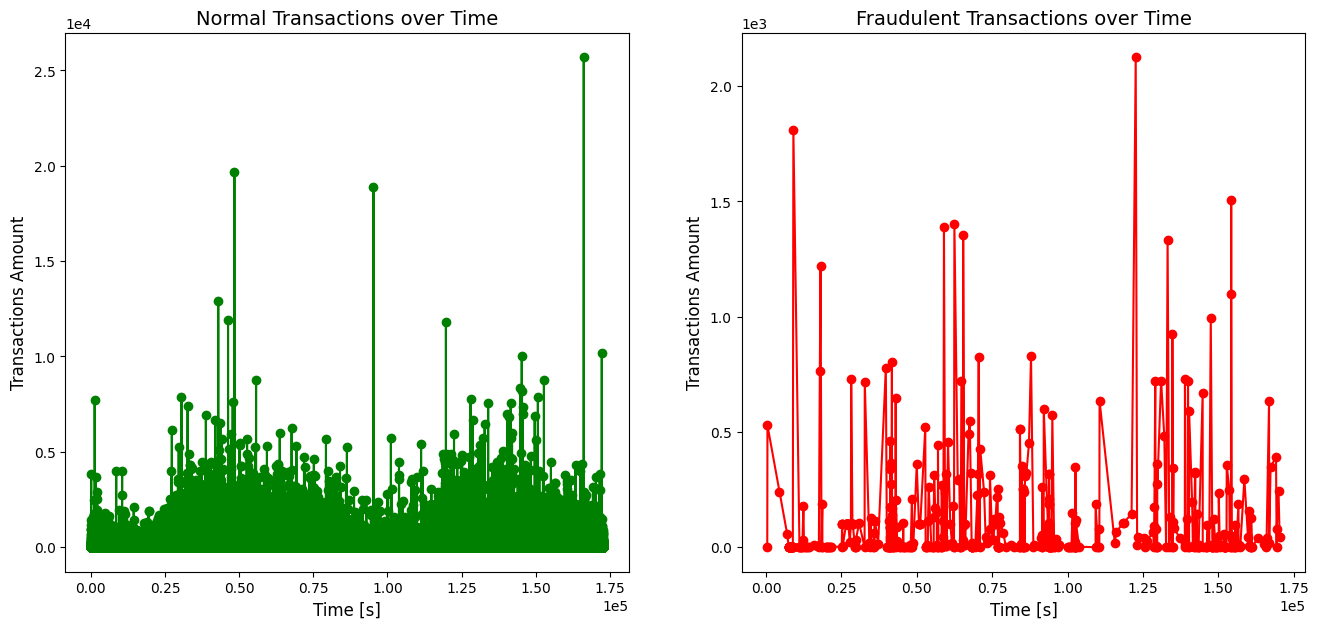

In [63]:
# Function to plot based on the passed arguments
def plot_line(x, y, title="", xlabel="", ylabel="", color=""):
    plt.plot(x, y, color)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.figure(figsize=(16, 7))
# Normal transactions on amount vs time chart
plt.subplot(1, 2, 1)
plot_line(
    x=normals["Time"],
    y=normals["Amount"],
    title="Normal Transactions over Time",
    xlabel="Time [s]",
    ylabel="Transactions Amount",
    color="g-o",
)
# Fraudulant transactions on amount vs time chart
plt.subplot(1, 2, 2)
plot_line(
    x=frauds["Time"],
    y=frauds["Amount"],
    title="Fraudulent Transactions over Time",
    xlabel="Time [s]",
    ylabel="Transactions Amount",
    color="r-o",
)

In [64]:
std_scaler = StandardScaler()
# Retrieving amount values to rescale
amount_vals = df['Amount'].values
# Standard Scaling amount values and reshaping as a column.
df['Amount'] = std_scaler.fit_transform(amount_vals.reshape(-1,1))

### Splitting Data & Creating Training Structures

In [70]:
# As the dataset is huge and it takes forever to run our models, 
# we're going to reduce the sample size to 50k choosing indices randomly
indices = np.array(df.loc[df['Class'] == 0].index)
rands = np.random.choice(indices, 49502, replace = False)
random_normals = df.iloc[rands, :]
frames = [frauds, random_normals]
df = pd.concat(frames)
df = df.sample(frac=1).reset_index(drop=True)

y = np.array(df['Class'])
X = np.array(df.loc[:, df.columns != 'Class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10, shuffle=True)

print("Before oversampling the data: ")
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("\n")

# We are going to oversample the dataset and create new synthetic data samples resembling the minority class
ros = RandomOverSampler(sampling_strategy="minority", random_state=1)
X_over_train, y_over_train = ros.fit_resample(X_train, y_train)
X_over_test, y_over_test = ros.fit_resample(X_test, y_test)

print("After oversampling the data: ")
print("X_over_train Shape: ", X_over_train.shape)
print("X_test Shape: ", X_test.shape)
print("\n")

rus = RandomUnderSampler(random_state = 1)
X_under_train, y_under_train = rus.fit_resample(X_train, y_train)
X_under_test, y_under_test = rus.fit_resample(X_test, y_test)

print("After undersampling the data: ")
print("X_under_train Shape: ", X_under_train.shape)
print("X_test Shape: ", X_test.shape)

# models = []
scores = ["precision", "accuracy", "recall", "F1", "ROC"]
confusion_matrix_results = {}

Before oversampling the data: 
X_train Shape:  (39995, 21)
X_test Shape:  (9999, 21)


After oversampling the data: 
X_over_train Shape:  (79196, 21)
X_test Shape:  (9999, 21)


After undersampling the data: 
X_under_train Shape:  (794, 21)
X_test Shape:  (9999, 21)


### Logistic Regression

In [66]:
# Tuning lambda parameter for all models
#lambda1 = 1000000
# Appending Logistic Regression model with l2 regularization
#models.append(("Logistic", LogisticRegression(penalty = "l2", dual = False, C = lambda1)))

### Support Vector Machine (SVM)

In [67]:
# Appending SVM with balanced weights
#models.append(("SVM", SVC(class_weight = "balanced", probability = True, C = lambda1)))

### Artificial Neural Network (ANN)

In [73]:
# ANN with 1 hidden layers with sizes of (200, )
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras import metrics

model = Sequential()
my_lambdas = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100]
for lambda1 in my_lambdas:
# Frist layer with 200 neurons 
    model.add(Dense(200, input_shape=(21,), kernel_regularizer = regularizers.L1(lambda1), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    model.fit(X_over_train, y_over_train, epochs=5, batch_size=10)
    results = model.evaluate(X_over_test, y_over_test)
    print(results)

Epoch 1/5
7920/7920 [==============================] - 11s 1ms/step - loss: 49.9693 - accuracy: 0.8129 - precision_15: 0.8039 - recall_15: 0.8277
Epoch 2/5
7920/7920 [==============================] - 11s 1ms/step - loss: 24.2430 - accuracy: 0.9019 - precision_15: 0.8940 - recall_15: 0.9120
Epoch 3/5
7920/7920 [==============================] - 11s 1ms/step - loss: 18.1313 - accuracy: 0.9209 - precision_15: 0.9139 - recall_15: 0.9293
Epoch 4/5
7920/7920 [==============================] - 13s 2ms/step - loss: 14.4239 - accuracy: 0.9315 - precision_15: 0.9254 - recall_15: 0.9385
Epoch 5/5
619/619 [==============================] - 1s 1ms/step - loss: 1.9469 - accuracy: 0.9697 - precision_15: 0.9517 - recall_15: 0.9895
[1.94694983959198, 0.9696587324142456, 0.9517335295677185, 0.9894992113113403]


In [ ]:
cm = pd.DataFrame(
        confusion_matrix(y_over_test, y_pred),
        columns=["Predicted Positive", "Predicted Negative"],
        index=["Actual Positive", "Actual Negative"],
    )
plt.suptitle("Confusion Matrix", fontsize=16)
sns.heatmap(
    cm,
    cmap="RdYlGn",
    linewidth=0.2,
    annot=True,
    cbar=False,
)
plt.title("Matrix for ANN")
plt.show()

NameError: name 'y_pred' is not defined

### Observation